In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

E0000 00:00:1728309664.982287      12 common_lib.cc:798] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: === 
learning/45eac/tfrc/runtime/common_lib.cc:479
D1007 14:01:04.990664506      12 config.cc:196]                        gRPC EXPERIMENT call_status_override_on_cancellation   OFF (default:OFF)
D1007 14:01:04.990680144      12 config.cc:196]                        gRPC EXPERIMENT call_v3                                OFF (default:OFF)
D1007 14:01:04.990683400      12 config.cc:196]                        gRPC EXPERIMENT canary_client_privacy                  ON  (default:ON)
D1007 14:01:04.990685833      12 config.cc:196]                        gRPC EXPERIMENT capture_base_context                   ON  (default:ON)
D1007 14:01:04.990688198      12 config.cc:196]                        gRPC EXPERIMENT client_idleness                        ON  (defa

In [2]:
# Load the dataset
data = np.load('/kaggle/input/1024age5/AGE_1024_512_Class5.npz')
X_train, y_train = data['X_train'], data['y_train']
X_test, y_test = data['X_test'], data['y_test']

# Reshape the images (from flat to original size)
X_train = X_train.reshape((-1, 512, 1024, 1))  # Grayscale
X_test = X_test.reshape((-1, 512, 1024, 1))

# Convert grayscale to 3 channels by repeating the single channel
X_train = np.repeat(X_train, 3, axis=-1)
X_test = np.repeat(X_test, 3, axis=-1)

# Normalize pixel values (0-255) to range (0-1)
X_train = X_train / 255.0
X_test = X_test / 255.0

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (9154, 512, 1024, 3)
y_train shape: (9154, 5)
X_test shape: (2289, 512, 1024, 3)
y_test shape: (2289, 5)


In [3]:
import tensorflow as tf

# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()

# instantiate a distribution strategy
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)

# Create a strategy for distributed training
#strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local


I0000 00:00:1728309809.118948      12 service.cc:145] XLA service 0x5d0be6211c40 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728309809.119007      12 service.cc:153]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1728309809.119011      12 service.cc:153]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1728309809.119014      12 service.cc:153]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1728309809.119017      12 service.cc:153]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1728309809.119020      12 service.cc:153]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1728309809.119022      12 service.cc:153]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1728309809.119024      12 service.cc:153]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1728309809.119027      12 service.cc:153]   StreamExecutor device (7): TPU, 2a886c8


INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)
I

In [4]:
with tpu_strategy.scope():
    # Define the base model with ImageNet weights, without the top layers
    base_model = ResNet152V2(weights='imagenet', include_top=False, input_shape=(512, 1024, 3))

    # Freeze the base model layers
    base_model.trainable = False

    # Add custom layers on top of the base model
    inputs = Input(shape=(512, 1024, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)  # Global average pooling layer
    x = Dense(128, activation='relu')(x)  # Custom dense layer
    outputs = Dense(5, activation='softmax')(x)  # Output layer for 2 classes

    # Create the final model
    model = Model(inputs, outputs)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
model.summary()

I0000 00:00:1728309814.204542      12 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


234545216/234545216 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 512, 1024, 3)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet152v2 (Functional)        │ (None, 16, 32, 2048)   │    58,331,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,594,565 (223.52 MB)

 Trainable params: 262,917 (1.00 MB)

 Non-trainable params: 58,331,648 (222.52 MB)

In [5]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=100,  # You can increase epochs based on performance
                    batch_size=32,
                    callbacks=[early_stopping])

# Save the model in .keras format
model.save('AP-ResNet152V2_Model_1024Age_Trained.keras')

Epoch 1/100


2024-10-07 14:06:55.839752: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node StatefulPartitionedCall.
I0000 00:00:1728310018.201909     827 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(43ba76105f1bb565:0:0), session_name()


  1/287 ━━━━━━━━━━━━━━━━━━━━ 2:21:47 30s/step - accuracy: 0.2500 - loss: 2.3313

I0000 00:00:1728310035.372207     827 tpu_compile_op_common.cc:245] Compilation of 43ba76105f1bb565:0:0 with session name  took 17.170238688s and succeeded
I0000 00:00:1728310035.404452     827 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(43ba76105f1bb565:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_16093562984962817134", property.function_library_fingerprint = 9159821892485764128, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "4,512,1024,3,;4,5,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1728310035.404514     827 tpu_compilation_cache_interface.cc:541] After adding entry for key

286/287 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.2776 - loss: 1.6205

I0000 00:00:1728310077.000501     798 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(e204dabd450d2320:0:0), session_name()


287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.2778 - loss: 1.6201

I0000 00:00:1728310091.791073     798 tpu_compile_op_common.cc:245] Compilation of e204dabd450d2320:0:0 with session name  took 14.790525875s and succeeded
I0000 00:00:1728310091.814861     798 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(e204dabd450d2320:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_16093562984962817134", property.function_library_fingerprint = 9159821892485764128, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "2,512,1024,3,;2,5,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1728310091.814904     798 tpu_compilation_cache_interface.cc:541] After adding entry for key

287/287 ━━━━━━━━━━━━━━━━━━━━ 199s 591ms/step - accuracy: 0.2781 - loss: 1.6197 - val_accuracy: 0.3763 - val_loss: 1.4384
Epoch 2/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 59s 200ms/step - accuracy: 0.4464 - loss: 1.3324 - val_accuracy: 0.4146 - val_loss: 1.3755
Epoch 3/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 58s 199ms/step - accuracy: 0.4524 - loss: 1.3245 - val_accuracy: 0.4669 - val_loss: 1.3453
Epoch 4/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 55s 188ms/step - accuracy: 0.4764 - loss: 1.2592 - val_accuracy: 0.4704 - val_loss: 1.3231
Epoch 5/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 55s 188ms/step - accuracy: 0.4610 - loss: 1.2912 - val_accuracy: 0.4669 - val_loss: 1.2996
Epoch 6/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 56s 188ms/step - accuracy: 0.4903 - loss: 1.2223 - val_accuracy: 0.4530 - val_loss: 1.3148
Epoch 7/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 55s 190ms/step - accuracy: 0.4632 - loss: 1.2426 - val_accuracy: 0.4843 - val_loss: 1.2790
Epoch 8/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 53s 183ms/step - accuracy: 0.5032 - loss: 1.19

ValueError: Device /job:localhost/replica:0/task:0/device:CPU:0 is not found

In [6]:
# Evaluate on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc * 100:.2f}%")

72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 124ms/step - accuracy: 0.5423 - loss: 1.1640
Test accuracy: 56.79%


In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import tensorflow.keras.optimizers as optimizers
import matplotlib.pyplot as plt

# Get the default learning rate for the Adam optimizer
d_learning_rate = optimizers.Adam().get_config()['learning_rate']

# Predictions
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

# Metrics calculation
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Additional information
print("Number of Epochs:", len(history.history['accuracy']))
print("Size of Image:", X_train.shape[1:])
print("Learning Rate: ",d_learning_rate)

2024-10-07 15:04:21.611724: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node functional_1/dense_1/Add/ReadVariableOp.
I0000 00:00:1728313462.757585     819 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(e92578ddf137f48d:0:0), session_name()


 1/72 ━━━━━━━━━━━━━━━━━━━━ 22:20 19s/step

I0000 00:00:1728313474.442930     819 tpu_compile_op_common.cc:245] Compilation of e92578ddf137f48d:0:0 with session name  took 11.685286953s and succeeded
I0000 00:00:1728313474.467692     819 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(e92578ddf137f48d:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_8774630259282845527", property.function_library_fingerprint = 12366218446743020095, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1728313474.467751     819 tpu_compilation_cache_interface.cc:541] After adding entry for key e92578ddf1

71/72 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step

I0000 00:00:1728313504.914632     742 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(8dcde9a90e69d526:0:0), session_name()


72/72 ━━━━━━━━━━━━━━━━━━━━ 62s 608ms/step


I0000 00:00:1728313517.598201     742 tpu_compile_op_common.cc:245] Compilation of 8dcde9a90e69d526:0:0 with session name  took 12.683521808s and succeeded
I0000 00:00:1728313517.627185     742 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(8dcde9a90e69d526:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_13311351207025542510", property.function_library_fingerprint = 15198630497501322049, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "3,512,1024,3,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1728313517.627244     742 tpu_compilation_cache_interface.cc:541] After adding entry for

Accuracy: 0.6024464831804281
Precision: 0.6002734566683686
Recall: 0.6041109308069876
F1 Score: 0.5982683771481898
Number of Epochs: 54
Size of Image: (512, 1024, 3)
Learning Rate:  0.0010000000474974513


72/72 ━━━━━━━━━━━━━━━━━━━━ 26s 344ms/step


<Figure size 1600x1600 with 0 Axes>

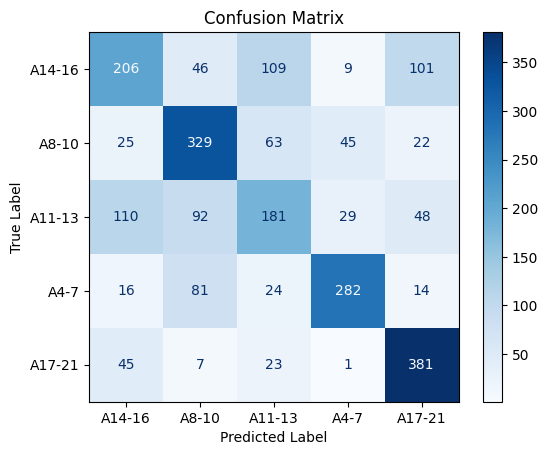

In [8]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Evaluate the model and get predictions
y_pred = model.predict(X_test)

# Convert the predictions from one-hot encoded to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot the confusion matrix
labels = ['A14-16', 'A8-10', 'A11-13', 'A4-7', 'A17-21']  # Adjust according to your labels

plt.figure(figsize=(16, 16))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues, values_format='d')

# Add title and axis labels
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Show the plot
plt.show()

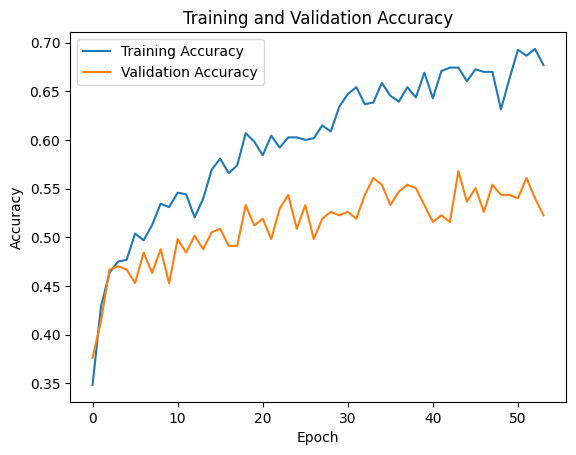

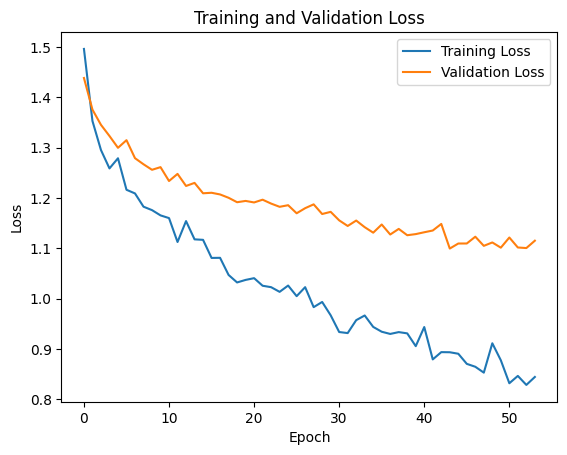

In [9]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()